In [2]:
%load_ext autoreload
%autoreload 2

# Covert models to tensorrt
In this notebook, we take the trained models from the previous notebooks and convert them to tensorrt models, which perform inference much faster. 

In [3]:
# Set up the environment variables
PATH_TO_MMDEPLOY = "/n/groups/datta/tim_sainburg/projects/mmdeploy/"

### Choose GPU
Each model is compiled for the specific GPU on your machine

In [4]:
import torch

In [5]:
device_number = 0

In [6]:
device_name = torch.cuda.get_device_name(device_number).replace(' ', '_')
print(device_name)

Tesla_V100S-PCIE-32GB


### Register the new dataset
- this is needed to build the dataset into the end-to-end model

In [7]:
from mmpipeline.paths import PACKAGE_DIR, MODEL_DIR

In [8]:
PACKAGE_DIR

PosixPath('/n/groups/datta/tim_sainburg/projects/24-01-05-multicamera_keypoints_mm2d/mmpipeline')

In [9]:
from mmpose.registry import DATASETS
from mmpose.datasets.datasets.base import BaseCocoStyleDataset

In [10]:
# this file contains info about the dataset (keypoints, skeleton, etc) needed for traiing
dataset_info_loc =  PACKAGE_DIR / 'mmpose' / 'skeletons' / 'sainburg25pt.py'

In [11]:
@DATASETS.register_module()
class CoCo25pt(BaseCocoStyleDataset):
    METAINFO: dict = dict(from_file=dataset_info_loc)

### Choose models

##### rtmdetection

In [12]:
!ls {(MODEL_DIR / 'rtmdet').as_posix()}

rtmdet_small_8xb32-300e_coco_24-04-03-11-48-16_097276
rtmdet_small_8xb32-300e_coco_24-04-08-15-07-37_128403
rtmdet_small_8xb32-300e_coco_24-04-08-15-12-06_128206
rtmdet_small_8xb32-300e_coco_chronic_24-04-08-16-27-57_624033
rtmdet_small_8xb32-300e_coco_chronic_24-04-09-09-12-45_918715
rtmdet_small_8xb32-300e_coco_chronic_24-04-09-09-13-14_300317
rtmdet_small_8xb32-300e_coco_chronic_24-04-23-17-28-05_902429
rtmdet_small_8xb32-300e_coco_chronic_24-04-23-17-29-07_780522
rtmdet_small_8xb32-300e_coco_chronic_24-04-24-07-51-48_566383
rtmdet_small_8xb32-300e_coco_chronic_24-04-24-15-33-45_897225
rtmdet_small_8xb32-300e_coco_chronic_24-04-24-15-51-46_880349
rtmdet_tiny_8xb32-300e_coco_24-01-05-11-25-00_102726
rtmdet_tiny_8xb32-300e_coco_24-01-05-11-25-00_102726_continue_training
rtmdet_tiny_8xb32-300e_coco_24-04-02-21-42-29_162984
rtmdet_tiny_8xb32-300e_coco_24-04-02-21-47-57_346352
rtmdet_tiny_8xb32-300e_coco_24-04-02-21-48-31_242533
rtmdet_tiny_8xb32-300e_coco_chronic_24-05-01-20-55-31_30296

In [13]:
model_folder_rtmdetection = MODEL_DIR / 'rtmdet' / 'rtmdet_tiny_8xb32-300e_coco_chronic_24-05-04-17-51-58_216661'

In [14]:
!ls {(model_folder_rtmdetection).as_posix()}

20240504_175210  epoch_400.pth	epoch_650.pth  epoch_900.pth
config.py	 epoch_450.pth	epoch_700.pth  epoch_950.pth
epoch_250.pth	 epoch_500.pth	epoch_750.pth  last_checkpoint
epoch_300.pth	 epoch_550.pth	epoch_800.pth  rtmdet_tiny_8xb32-300e_coco.py
epoch_350.pth	 epoch_600.pth	epoch_850.pth


In [15]:
path_to_rtmdetection_config = (model_folder_rtmdetection / 'config.py').as_posix()
path_to_rtmdetection_weights = (model_folder_rtmdetection / 'epoch_400.pth').as_posix()

In [16]:
path_to_rtmdetection_weights

'/n/groups/datta/tim_sainburg/projects/24-01-05-multicamera_keypoints_mm2d/models/rtmdet/rtmdet_tiny_8xb32-300e_coco_chronic_24-05-04-17-51-58_216661/epoch_400.pth'

In [17]:
path_to_rtmdetection_config

'/n/groups/datta/tim_sainburg/projects/24-01-05-multicamera_keypoints_mm2d/models/rtmdet/rtmdet_tiny_8xb32-300e_coco_chronic_24-05-04-17-51-58_216661/config.py'

### Convert detection model to tensortt

In [18]:
import sys
from datetime import datetime
from pathlib import Path
import subprocess

In [19]:
import mmengine

In [20]:
conda_env = (Path(sys.executable).parents[1]).as_posix()
print(conda_env)

/n/groups/datta/tim_sainburg/conda_envs/mmdeploy


In [21]:
# choose the demo image
path_to_demo_image = (PACKAGE_DIR.parent / 'example_data/test_mouse.png').as_posix()

In [22]:
#sys.path.append((Path(PATH_TO_MMDEPLOY) / 'tools').as_posix())
#import deploy

In [23]:
!ls /n/groups/datta/tim_sainburg/projects/mmdeploy/configs/mmdet/detection/

detection_ascend_dynamic-800x1344.py
detection_ascend_static-640x640.py
detection_coreml_static-800x1344.py
detection_onnxruntime_dynamic.py
detection_onnxruntime-fp16_dynamic.py
detection_onnxruntime_static.py
detection_openvino_dynamic-300x300.py
detection_openvino_dynamic-640x640.py
detection_openvino_dynamic-800x1344.py
detection_pplnn_dynamic-800x1344.py
detection_rknn-fp16_static-320x320.py
detection_rknn-int8_static-320x320.py
detection_rknn-int8_static-640x640.py
detection_sdk_dynamic.py
detection_tensorrt_dynamic-300x300-512x512.py
detection_tensorrt_dynamic-320x320-1344x1344.py
detection_tensorrt_dynamic-64x64-608x608.py
detection_tensorrt_dynamic-64x64-800x800.py
detection_tensorrt-fp16_dynamic-300x300-512x512.py
detection_tensorrt-fp16_dynamic-320x320-1344x1344.py
detection_tensorrt-fp16_dynamic-64x64-608x608.py
detection_tensorrt-fp16_dynamic-64x64-800x800.py
detection_tensorrt-fp16_static-320x320.py
detection_tensorrt-fp16_static-800x1344.py
detection_tensorrt-int8_dynami

In [24]:
# select how to deploy (e.g. tensortt vs onyx)
path_to_deploy_config = (Path(PATH_TO_MMDEPLOY) / 'configs/mmdet/detection/detection_tensorrt_static-320x320.py').as_posix()

In [25]:
path_to_deploy_config

'/n/groups/datta/tim_sainburg/projects/mmdeploy/configs/mmdet/detection/detection_tensorrt_static-320x320.py'

In [26]:
# choose the working directory
prefix = f'rtmdetection_fp32_{device_name}-{device_number}_'
formatted_datetime = datetime.now().strftime("%y-%m-%d-%H-%M-%S_%f")
working_directory = (MODEL_DIR / 'tensortt' / f"{prefix}_{formatted_datetime}").as_posix()

In [27]:
model_conversion_script = f"""
module load cuda/11.7
source activate {conda_env};


# Run the command to convert RTMDet
python {PATH_TO_MMDEPLOY}tools/deploy.py \
    {path_to_deploy_config} \
    {path_to_rtmdetection_config} \
    {path_to_rtmdetection_weights} \
    {path_to_demo_image} \
    --work-dir {working_directory} \
    --device cuda:{device_number} \
    --show \
    --dump-info  # dump sdk info
"""
print(model_conversion_script)


module load cuda/11.7
source activate /n/groups/datta/tim_sainburg/conda_envs/mmdeploy;


# Run the command to convert RTMDet
python /n/groups/datta/tim_sainburg/projects/mmdeploy/tools/deploy.py     /n/groups/datta/tim_sainburg/projects/mmdeploy/configs/mmdet/detection/detection_tensorrt_static-320x320.py     /n/groups/datta/tim_sainburg/projects/24-01-05-multicamera_keypoints_mm2d/models/rtmdet/rtmdet_tiny_8xb32-300e_coco_chronic_24-05-04-17-51-58_216661/config.py     /n/groups/datta/tim_sainburg/projects/24-01-05-multicamera_keypoints_mm2d/models/rtmdet/rtmdet_tiny_8xb32-300e_coco_chronic_24-05-04-17-51-58_216661/epoch_400.pth     /n/groups/datta/tim_sainburg/projects/24-01-05-multicamera_keypoints_mm2d/example_data/test_mouse.png     --work-dir /n/groups/datta/tim_sainburg/projects/24-01-05-multicamera_keypoints_mm2d/models/tensortt/rtmdetection_fp32_Tesla_V100S-PCIE-32GB-0__24-08-07-14-19-10_374392     --device cuda:0     --show     --dump-info  # dump sdk info



In [28]:
process = subprocess.Popen(
    model_conversion_script,
    shell=True,
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    bufsize=1,
    universal_newlines=True,
    executable="/bin/bash"
)
# Read output line by line as it is produced
for line in process.stdout:
    print(line, end='')
    
# Wait for the subprocess to finish
process.wait()


The following have been reloaded with a version change:
  1) cuda/12.1 => cuda/11.7

08/07 14:19:45 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "Codebases" registry tree. As a workaround, the current "Codebases" registry in "mmdeploy" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.
08/07 14:19:45 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "mmdet_tasks" registry tree. As a workaround, the current "mmdet_tasks" registry in "mmdeploy" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.
08/07 14:19:53 - mmengine - INFO - Start pipeline mmdeploy.apis.pytorch2onnx.torch2onnx in subprocess
08/07 14:19:57 - mmengine - WARNING - Failed to search registry with scope "mmdet"

[08/07/2024-14:21:58] [TRT] [I] Detected 1 inputs and 2 output network tensors.
[08/07/2024-14:21:58] [TRT] [I] Total Host Persistent Memory: 387072
[08/07/2024-14:21:58] [TRT] [I] Total Device Persistent Memory: 11264
[08/07/2024-14:21:58] [TRT] [I] Total Scratch Memory: 197120
[08/07/2024-14:21:58] [TRT] [I] [MemUsageStats] Peak memory usage of TRT CPU/GPU memory allocators: CPU 6 MiB, GPU 23 MiB
[08/07/2024-14:21:58] [TRT] [I] [BlockAssignment] Started assigning block shifts. This will take 258 steps to complete.
[08/07/2024-14:21:58] [TRT] [I] [BlockAssignment] Algorithm ShiftNTopDown took 13.8765ms to assign 11 blocks to 258 nodes requiring 6708736 bytes.
[08/07/2024-14:21:58] [TRT] [I] Total Activation Memory: 6707200
[08/07/2024-14:21:58] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +8, now: CPU 659, GPU 1918 (MiB)
[08/07/2024-14:21:58] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +0, GPU +10, now: CPU 659, GPU 1928 (MiB)
[08/07/2024-14:21:58] [TRT] [I] [MemUsageCh

0

##### Confirm everything worked
If everything worked you should see an end2end.engine file

In [29]:
print(working_directory)

/n/groups/datta/tim_sainburg/projects/24-01-05-multicamera_keypoints_mm2d/models/tensortt/rtmdetection_fp32_Tesla_V100S-PCIE-32GB-0__24-08-07-14-19-10_374392


In [30]:
!ls {working_directory}

deploy.json  end2end.engine  output_pytorch.jpg   pipeline.json
detail.json  end2end.onnx    output_tensorrt.jpg


In [31]:
import matplotlib.pyplot as plt

In [32]:
image = plt.imread(Path(working_directory) / 'output_tensorrt.jpg')

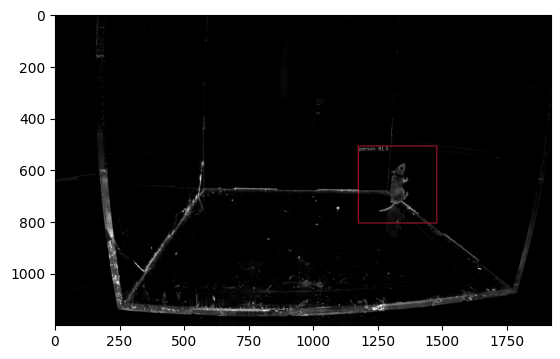

In [33]:
plt.imshow(image)

In [34]:
!ls '/n/groups/datta/tim_sainburg/projects/23-09-29-peromoseq/data'

240314-chronic-calibration  all_species.npy	   hmm	      nacho
all_cycle.npy		    all_syllables.pickle   indv.npy   sleap
all_distance.npy	    animation.mp4	   jarvis     snub
all_offset_front_back.npy   CalibrationParameters  keypoints  test-keypoints
all_phase.npy		    changepoint		   kpms       z_umap.npy
all_projections.npy	    gimbal		   mmpose
